# read dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/MyDrive/DeepLearningGSLC2/train.csv"
test_path  = "/content/drive/MyDrive/DeepLearningGSLC2/test.csv"

import pandas as pd

train_df = pd.read_csv(train_path, encoding="latin1")
test_df  = pd.read_csv(test_path, encoding="latin1")

train_df.head()


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


# clean dan normalisasi dataset (preprocessing)

In [ ]:
TEXT_COL = "text"
LABEL_COL = "sentiment"

In [ ]:
# cek missing value
print(train_df.isnull().sum())
print(test_df.isnull().sum())

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64
textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64


In [ ]:
# buang baris kosong
train_df = train_df.dropna(subset=[TEXT_COL, LABEL_COL])
test_df  = test_df.dropna(subset=[TEXT_COL, LABEL_COL])

In [ ]:
# normalisasi label jadi tiga kelas: 0=negative, 1=neutral, 2=positive
label_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2,
    0: 0, 1: 1, 2: 2
}
train_df["label"] = train_df[LABEL_COL].map(label_mapping)
test_df["label"]  = test_df[LABEL_COL].map(label_mapping)

print(train_df["label"].value_counts())


label
1    11117
2     8582
0     7781
Name: count, dtype: int64


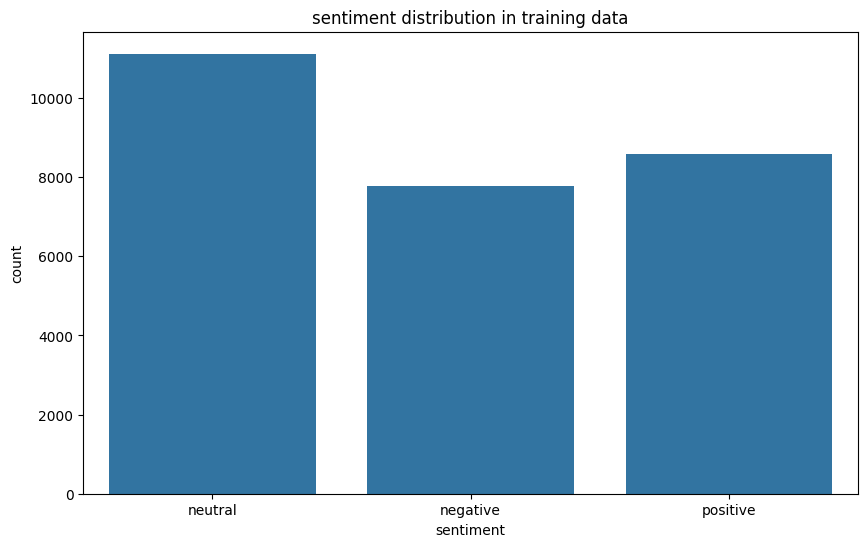

In [ ]:
# visualisasi distribusi label
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=train_df)
plt.title('sentiment distribution in training data')
plt.show()

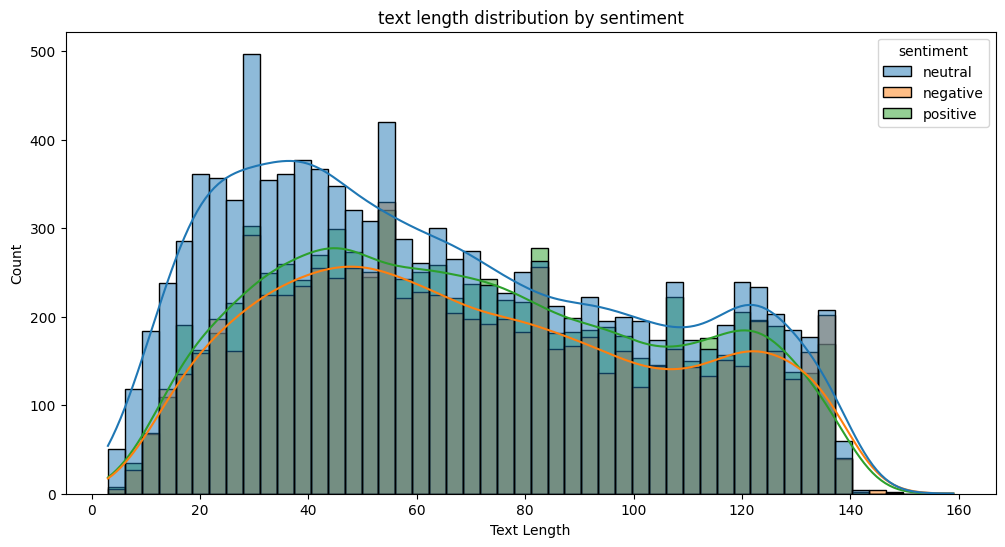

In [ ]:
# mengkonvert kolom text menjadi string
# untuk menghindari baris NaN
train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

# menghitung panjang text, kemudian di tampilkan dalam plot
# untuk melihat apakah tiap sentiment ini memiliki pola panjang tertentu
train_df['text_length'] = train_df['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='text_length', hue='sentiment', bins=50, kde=True)
plt.title('text length distribution by sentiment')
plt.xlabel('Text Length')
plt.show()

In [ ]:
# teks cleaning
import re

def clean_tweet(text):
    text = str(text)
    text = re.sub(r"http\S+|www\.\S+", " ", text)      # hapus URL
    text = re.sub(r"@\w+", " ", text)                 # hapus mention
    text = re.sub(r"#", " ", text)                    # hilangkan '#'
    text = re.sub(r"[^0-9A-Za-z(),!?\'\"`]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

train_df["clean_text"] = train_df[TEXT_COL].apply(clean_tweet)
test_df["clean_text"]  = test_df[TEXT_COL].apply(clean_tweet)


In [ ]:
# split dataset
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

print(train_split.shape, val_split.shape)


(24732, 13) (2748, 13)


In [ ]:
# konversi ke HuggingFace
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(
    train_split[["clean_text", "label"]].reset_index(drop=True)
)
val_dataset = Dataset.from_pandas(
    val_split[["clean_text", "label"]].reset_index(drop=True)
)
test_dataset = Dataset.from_pandas(
    test_df[["clean_text", "label"]].reset_index(drop=True)
)

dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

dataset_dict


DatasetDict({
    train: Dataset({
        features: ['clean_text', 'label'],
        num_rows: 24732
    })
    validation: Dataset({
        features: ['clean_text', 'label'],
        num_rows: 2748
    })
    test: Dataset({
        features: ['clean_text', 'label'],
        num_rows: 3534
    })
})

In [ ]:
# tokenisasi -> mengubah teks menjadi token lalu menjadi input_ids
# memotong teks yang terlalu panjang
# menyamakan panjang
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(
        batch["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

encoded_datasets = dataset_dict.map(tokenize_batch, batched=True)

# Hapus kolom teks mentah, set format PyTorch
encoded_datasets = encoded_datasets.remove_columns(["clean_text"])
encoded_datasets.set_format("torch")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/24732 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

# model development

In [ ]:
# distelBERT pretrained, menambahkan classification head dengan 3 kelas
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from scipy.special import softmax

num_labels = 3
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v:k for k,v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Berikut versi kalimat yang sudah dirapikan, lebih formal, dan cocok dimasukkan ke laporan:

---

# model distilBERT digunakan karena ringan, cepat, dan tetap memiliki performa yang tinggi untuk analisa NLP. model ini sangat cocok untuk dataset sentimen, karena dataset ini berisi teks pendek, kalimat informal, serta banyak penggunaan slang, hashtag, dan singkatan. selain itu, DistilBERT telah dilatih pada korpus besar seperti Wikipedia dan BookCorpus, sehingga mampu memahami struktur bahasa yang bervariasi dan pola kalimat yang umum digunakan. sengan kemampuan ini, distilBERT dapat mengenali pola bahasa dalam data sentimen secara efektif.



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# evaluasi metrik (F1 & AUC)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    f1_macro = f1_score(labels, preds, average="macro")

    # hitung probabilitas menggunakan softmax
    probs = softmax(logits, axis=1)
    try:
        auc_macro = roc_auc_score(
            labels,
            probs,
            multi_class="ovo",
            average="macro"
        )
    except ValueError:
        # kalau ada class yang tidak muncul di batch
        auc_macro = float("nan")

    return {
        "f1_macro": f1_macro,
        "auc_macro": auc_macro
    }


In [ ]:
# konfigurasi training
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./distilbert-sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# melatih model (DistilBERT)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-4123565889.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Macro,Auc Macro
1,0.528200,0.550762,0.788389,0.922616
2,0.444400,0.526888,0.795853,0.926482
3,0.335100,0.681618,0.783687,0.918401
4,0.206100,0.846067,0.770019,0.910046
5,0.166500,1.121058,0.781269,0.896857
6,0.108700,1.254856,0.781683,0.891950
7,0.101600,1.386421,0.775221,0.889975
8,0.061500,1.511652,0.784630,0.879325
9,0.052000,1.597603,0.781314,0.875240
10,0.045700,1.650192,0.779135,0.873805


TrainOutput(global_step=15460, training_loss=0.2111722498630953, metrics={'train_runtime': 1578.1789, 'train_samples_per_second': 156.712, 'train_steps_per_second': 9.796, 'total_flos': 4095302662056960.0, 'train_loss': 0.2111722498630953, 'epoch': 10.0})

# evaluasi

In [ ]:
# test evaluasi
test_output = trainer.predict(encoded_datasets["test"])
test_metrics = test_output.metrics
test_metrics


{'test_loss': 0.5189675092697144,
 'test_f1_macro': 0.7897791493124194,
 'test_auc_macro': 0.9280497110896087,
 'test_runtime': 6.0532,
 'test_samples_per_second': 583.823,
 'test_steps_per_second': 18.337}

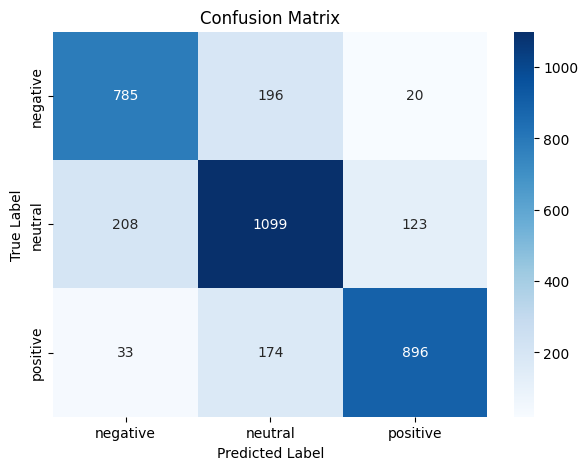

In [ ]:
# confussion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = np.array(encoded_datasets["test"]["label"])
y_pred = np.argmax(test_output.predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)
labels = [id2label[i] for i in range(num_labels)]

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

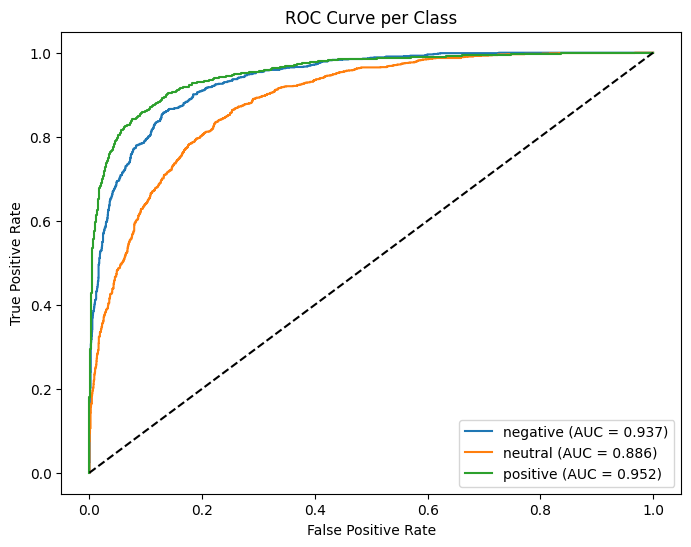

In [ ]:
# ROC-AUC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_bin = label_binarize(y_true, classes=[0,1,2])
probs = softmax(test_output.predictions, axis=1)

n_classes = probs.shape[1]

plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id2label[i]} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend()
plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report
import numpy as np

y_true = np.array(encoded_datasets["test"]["label"])
y_pred = np.argmax(test_output.predictions, axis=-1)

print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(num_labels)]
))


              precision    recall  f1-score   support

    negative       0.77      0.78      0.77      1001
     neutral       0.75      0.77      0.76      1430
    positive       0.86      0.81      0.84      1103

    accuracy                           0.79      3534
   macro avg       0.79      0.79      0.79      3534
weighted avg       0.79      0.79      0.79      3534



hasil evaluasi menunjukkan bahwa model mencapai akurasi sebesar 79%. nilai f1-score per kelas adalah 77% untuk negatif, 76% untuk netral, dan 84% untuk positif. hasil ini tergolong baik untuk dataset sentimen, karena data jenis ini biasanya mengandung banyak noise seperti penggunaan kata slang, simbol, singkatan, serta struktur kalimat informal.

berdasarkan confusion matrix, kelas netral merupakan kelas yang paling banyak mengalami salah prediksi, yaitu 208 kasus diprediksi sebagai negatif dan 123 kasus diprediksi sebagai positif. hal ini wajar karena komentar netral cenderung bersifat ambigu dan tidak memiliki kata-kata yang sangat jelas mengarah ke emosi positif atau negatif. sementara itu, kelas positif dan negatif sudah menunjukkan performa yang kuat, meskipun masih terdapat beberapa kasus yang salah diprediksi menjadi netral, yang kembali menunjukkan bahwa kelas netral memang lebih sulit dibedakan.

berdasarkan grafik roc-auc, kelas negatif memiliki nilai auc 0.937, yang menunjukkan bahwa model sangat baik dalam mengenali teks bernada negatif. kelas netral memiliki auc 0.886, yang berarti model cukup baik dalam memprediksi kelas ini, namun tidak sekuat dua kelas lainnya; model masih kesulitan membedakan netral dari positif atau negatif karena kalimat netral biasanya berupa ekspresi ambigu seperti “it’s okay” yang tidak memiliki emosi yang kuat. untuk kelas positif, nilai auc mencapai 0.952, menunjukkan bahwa model memiliki kemampuan yang sangat baik dalam mengidentifikasi teks positif.